In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date

In [2]:
### Reading CSVs
files = [i for i in os.listdir('ibb_transportation_data') if not i.startswith('.')]
df = pd.DataFrame()

for file in files:
    data = pd.read_csv(f'ibb_transportation_data/{file}')
    df = pd.concat([df, data])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241290 entries, 0 to 9798
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   DATE_TIME            241290 non-null  object
 1   TRANSPORT_TYPE_ID    241290 non-null  int64 
 2   TRANSPORT_TYPE_DESC  241290 non-null  object
 3   LINE                 241290 non-null  object
 4   TRANSFER_TYPE_ID     241290 non-null  int64 
 5   TRANSFER_TYPE        241290 non-null  object
 6   NUMBER_OF_PASSENGER  241290 non-null  int64 
 7   NUMBER_OF_PASSAGE    241290 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 16.6+ MB


In [4]:
df.head(2)

,DATE_TIME,TRANSPORT_TYPE_ID,TRANSPORT_TYPE_DESC,LINE,TRANSFER_TYPE_ID,TRANSFER_TYPE,NUMBER_OF_PASSENGER,NUMBER_OF_PASSAGE
0,2020-01-29 12:00:00,2,RAY,KADIKÖY-MODA,2,AKTARMA,59,59
1,2020-01-29 10:00:00,2,RAY,TELEFERİK MAÇKA - TAŞKIŞLA,2,NORMAL,13,15


In [5]:
df.isna().any()
df = df.drop_duplicates(keep='first')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241290 entries, 0 to 9798
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   DATE_TIME            241290 non-null  object
 1   TRANSPORT_TYPE_ID    241290 non-null  int64 
 2   TRANSPORT_TYPE_DESC  241290 non-null  object
 3   LINE                 241290 non-null  object
 4   TRANSFER_TYPE_ID     241290 non-null  int64 
 5   TRANSFER_TYPE        241290 non-null  object
 6   NUMBER_OF_PASSENGER  241290 non-null  int64 
 7   NUMBER_OF_PASSAGE    241290 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 16.6+ MB


### Getting Date and Hour

In [7]:
df['Date'] = df['DATE_TIME'].apply(lambda x: x.split(' ')[0])
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['DATE_TIME'].apply(lambda x: x.split(' ')[1].split(':')[0])
df['Hour'] = df['Hour'].astype('int32')

### Getting Days from Date

In [8]:
def getDay(dates):
    day = dates.day
    month = dates.month
    return date(2020,month,day).strftime('%A')

df['Day'] = df['Date'].apply(getDay)

### Getting Months

In [9]:
df['Month'] = df['Date'].apply(lambda x: x.month)

In [10]:
df.drop(['DATE_TIME','Date'], axis = 1, inplace = True)

In [11]:
df.head(2)

,TRANSPORT_TYPE_ID,TRANSPORT_TYPE_DESC,LINE,TRANSFER_TYPE_ID,TRANSFER_TYPE,NUMBER_OF_PASSENGER,NUMBER_OF_PASSAGE,Hour,Day,Month
0,2,RAY,KADIKÖY-MODA,2,AKTARMA,59,59,12,Wednesday,1
1,2,RAY,TELEFERİK MAÇKA - TAŞKIŞLA,2,NORMAL,13,15,10,Wednesday,1


## Density by Hours

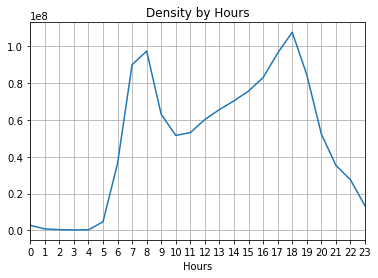

In [12]:
df.groupby('Hour')['NUMBER_OF_PASSENGER'].sum().plot.line(title = 'Density by Hours',
                                                          grid = True,
                                                          xlim = (0,23),
                                                          xlabel = 'Hours',
                                                          xticks = list(range(0,24)));

## Density by Days

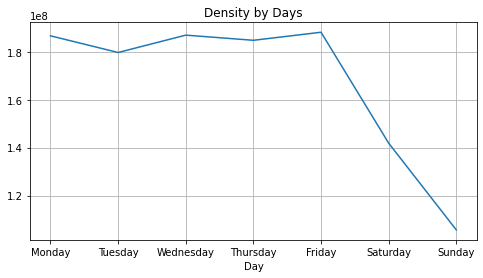

In [13]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby('Day')['NUMBER_OF_PASSENGER'].sum()[days].plot.line(title = 'Density by Days', 
                                                               grid = True, 
                                                               figsize = (8,4));

## Density by Months

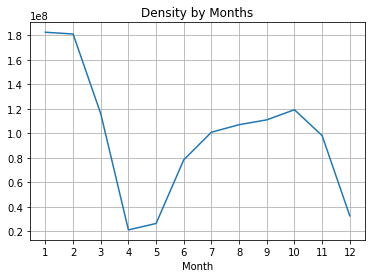

In [14]:
df.groupby('Month')['NUMBER_OF_PASSENGER'].sum().plot.line(title = 'Density by Months', 
                                                            grid = True, 
                                                            xticks = range(1,13));

In [15]:
#print(df['Month'].value_counts().sum(),
#df['Day'].value_counts().sum(),
#df['Hour'].value_counts().sum(),)

## Usage rates of public transportations

In [16]:
df_highway = df[df['TRANSPORT_TYPE_DESC'] == 'KARAYOLU']
df_rail = df[df['TRANSPORT_TYPE_DESC'] == 'RAY']
df_seaway = df[df['TRANSPORT_TYPE_DESC'] == 'DENİZ']

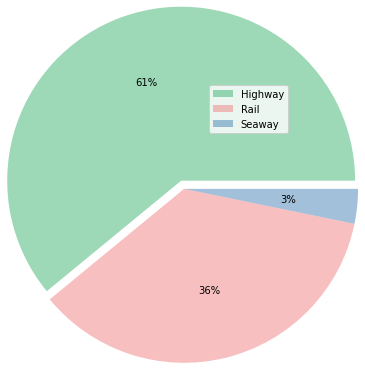

In [17]:
tp_types = ['Highway', 'Rail', 'Seaway']
hw_val = df_highway['NUMBER_OF_PASSENGER'].sum()
rl_val = df_rail['NUMBER_OF_PASSENGER'].sum()
sw_val = df_seaway['NUMBER_OF_PASSENGER'].sum()
vals = [hw_val, rl_val, sw_val]
expl = [0.1, 0, 0]
color = ['mediumseagreen', 'lightcoral', 'steelblue']

plt.pie(x=vals, 
        labels = tp_types, 
        colors = color,
        explode = expl,
        radius = 2,
        labeldistance = None,
        wedgeprops={'alpha':0.5},
        autopct='%1.f%%');
plt.legend();

## Density by railway lines

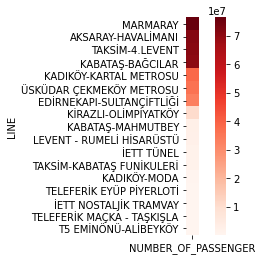

In [18]:
rail_lines_dens = pd.pivot_table(df_rail, 
                                 values = 'NUMBER_OF_PASSENGER',
                                 index=['LINE'],
                                 aggfunc=np.sum).sort_values(by='NUMBER_OF_PASSENGER',
                                                             ascending = False)
sns.heatmap(data= rail_lines_dens, cmap='Reds', robust=True, square = True);

## Lines Heatmap by Days (Rail)

In [19]:
rail_line_days = pd.pivot_table(df_rail,
               index = 'LINE',
               columns = 'Day',
               values = 'NUMBER_OF_PASSENGER',
               aggfunc = np.sum)[days].sort_values(ascending = False, by = days)

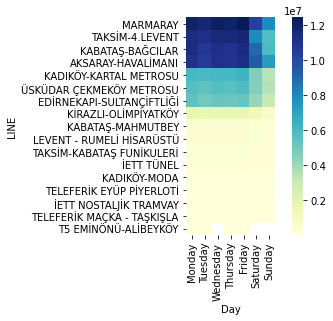

In [20]:
sns.heatmap(data = rail_line_days, cmap = 'YlGnBu', square = True);

## Highway

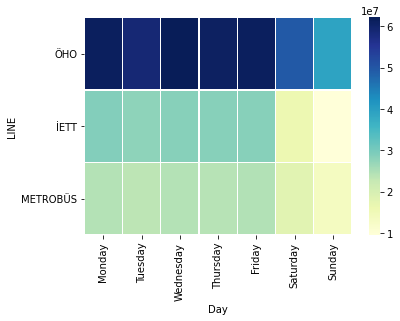

In [21]:
hway_line_day = pd.pivot_table(df_highway,
               values = 'NUMBER_OF_PASSENGER',
               index = 'LINE',
               columns = 'Day',
               aggfunc = 'sum')[days].sort_values(ascending = False, by = days)
sns.heatmap(hway_line_day, cmap = 'YlGnBu', square = False, linewidths=.1);
plt.yticks(rotation=0) ;

## Sea

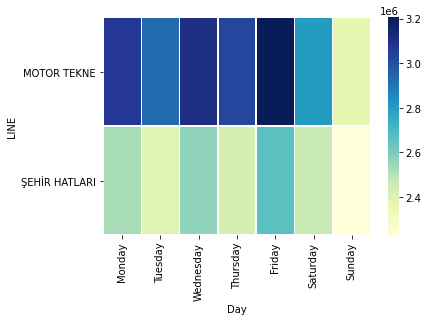

In [22]:
sway_line_day = pd.pivot_table(df_seaway,
               values = 'NUMBER_OF_PASSENGER',
               index = 'LINE',
               columns = 'Day',
               aggfunc = 'sum')[days].sort_values(ascending = False, by = days)

sns.heatmap(sway_line_day, cmap = 'YlGnBu', square = False, linewidths=.5);
plt.yticks(rotation=0);